# Calibration of models parameters: SPX
### based on European Put options
This notebook aims to find the optimal parameters of **Black-Scholes**, **Merton Jump Diffusion**, **Kou Jump Diffusion** and **Variance Gamma** models. To do so, we compute the european option prices using **closed formulas**, available for all the 4 models, and the **Fast Fourier Transform** for the VG model. Given these theoretical prices, the **implied volatilities** are computed comparing them with real market prices, minimizing their difference. Then we estimate the additional parameters of each model, using the python module `scipy.optimize`.

*reference: https://github.com/cantaro86/Financial-Models-Numerical-Methods/tree/master*


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import scipy as scp
import scipy.stats as ss
import scipy.optimize as scpo
import sys
sys.path.append('C:/Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules/functions')
sys.path.append('C:/Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules/calibration')
import time

from BSpricer import BS_Pricer
from MERTONpricer import Merton_pricer
from KOUpricer import Kou_pricer
from VGpricer import VG_pricer

random.seed(110)

Let's start retrieving historical prices for **european call** and **put** options starting from date **2016-01-20** and expiring **1 year** later. All the data have been collected from [OptionsDX](https://www.optionsdx.com/shop/) and preprocessed in `plainvanilla.py` module. Only options such that the moneyness
$$ K/S0 \in [0.75, 1.35] $$ have been selected.

In [4]:
df_put = pd.read_csv('../../data/SPX/OPT16_SPX_PUTS_restricted.csv')
print(f'NUM OF PUT OPTS: {df_put.shape[0]}')
print(df_put)

NUM OF PUT OPTS: 45
    QUOTE_DATE  UNDERLYING_LAST EXPIRE_DATE   P_BID   P_ASK  STRIKE     P_IV   
0   2016-01-20          1859.48  2017-01-20   45.50   47.89  1400.0  0.29263  \
1   2016-01-20          1859.48  2017-01-20   49.00   51.50  1425.0  0.28706   
2   2016-01-20          1859.48  2017-01-20   53.00   55.60  1450.0  0.28334   
3   2016-01-20          1859.48  2017-01-20   57.20   59.79  1475.0  0.27850   
4   2016-01-20          1859.48  2017-01-20   61.61   64.30  1500.0  0.27366   
5   2016-01-20          1859.48  2017-01-20   66.29   69.00  1525.0  0.26802   
6   2016-01-20          1859.48  2017-01-20   71.10   73.89  1550.0  0.26297   
7   2016-01-20          1859.48  2017-01-20   76.40   79.31  1575.0  0.25853   
8   2016-01-20          1859.48  2017-01-20   82.10   85.00  1600.0  0.25373   
9   2016-01-20          1859.48  2017-01-20   88.40   91.30  1625.0  0.24869   
10  2016-01-20          1859.48  2017-01-20   94.79   97.70  1650.0  0.24447   
11  2016-01-20      

The dataframes **df_calls** and **df_put** contain both 83 options sorted by strike price. For our purpose, using the $25\%$ of these DFs is enough and can lead to very good results. Thus, we sample the rows and then reformulate the dataframes adding **Midpoint** and **Spread** columns.

In [5]:
puts = df_put.sample(frac=0.4, replace=False).sort_index().reset_index(drop=True)

puts['P_Midpoint'] = abs(puts['P_BID'] + puts['P_ASK']) / 2
puts['P_Spread'] = puts['P_BID'] - puts['P_ASK']
put_prices = puts['P_Midpoint']


q = 0           # dividend yield
r = 0.03        # risk-free interest rate
sigma = 0.3     #volatility (variance of diffusion process)
S0 = puts.iloc[0]['UNDERLYING_LAST']
T = 1           # time-to-maturity
put_strikes = puts['STRIKE']      # array of K for put options
exercise = 'european'


The following code snippet initializes objects of class *BS_pricer*, *Merton_pricer*, *Kou_pricer*, *VG_pricer* with default values as parameters. Then it computes the theoretical call prices using closed formulas of each 4 models, with strike prices given by the *call_strikes* array. Additionally, we use the **Midpoint** price as the option market prices.P

In [6]:
BS = BS_Pricer(S0=S0, r=r, q = q, sigma=sigma, ttm=T, exercise=exercise, K=None)
Merton = Merton_pricer(S0=S0, K=None, ttm=T, r=r, q = q, sigma=0.15, lambd=0.5, meanJ=-0.1, stdJ=0.1, exercise=exercise)
Kou = Kou_pricer(S0=S0, K=None, ttm=T, r=r, sigma=0.15, lambd=0.5, p=0.6, eta1=12, eta2=5, exercise=exercise)
VG = VG_pricer(S0, K=None, ttm=T, r=r, q=q, sigma=0.15, theta=-0.2, nu=0.3, exercise=exercise)

Same for put prices.

In [7]:
put_th_prices = pd.DataFrame(columns=['Strike','Price', 'BlackScholes', 'Merton', 'Kou', 'VarianceGamma'])
put_th_prices['Strike'] = put_strikes
put_th_prices['Price'] = put_prices

for i, K in enumerate(put_strikes):
    bs = BS.closed_formula_put(K)
    mert = Merton.closed_formula_put(K)
    kou = Kou.closed_formula_put(K)
    vg = VG.closed_formula_put(K)
    put_th_prices.iloc[i, 2:] = [bs, mert, kou, vg]

print(f'Theoretical put options prices:')
print(put_th_prices)

Theoretical put options prices:
    Strike    Price BlackScholes      Merton         Kou VarianceGamma
0   1425.0   50.250    40.785423    8.558364   15.305761      2.237046
1   1575.0   77.855    77.644827   23.776709   31.076103     14.169185
2   1600.0   83.550    85.326996   27.696555   35.011394     18.186428
3   1625.0   89.850    93.464423   32.108695   39.427598      22.96569
4   1650.0   96.245   102.060063   37.049261   44.365303     28.550877
5   1675.0  103.090   111.115646   42.553175   49.863676     34.972637
6   1750.0  126.005   141.041839   62.763867   70.076875     59.383836
7   1825.0  153.710   175.061769   89.067281   96.455702     91.380433
8   1875.0  175.050    199.95869  110.218212  117.701468     116.64285
9   1900.0  186.700   213.053813  121.900461  129.440423    130.362596
10  1950.0  211.850   240.499961  147.469498  155.129349    159.809339
11  2000.0  239.850   269.564469   175.91478  183.683915    191.700745
12  2050.0  270.945   300.173985  207.105976 

## Implied volatility
The function belows implements $3$ methods to compute implied volatility: [Newton](https://en.wikipedia.org/wiki/Newton%27s_method) method, the [Bisection](https://en.wikipedia.org/wiki/Bisection_method) method and a more advanced one, named [Brent](https://en.wikipedia.org/wiki/Brent%27s_method) method. Apart from the initial guess, there is no substantial difference in the final result between **Newton** and **bisection** methods (*fsolve*). The **Implied Volatility** is that value $\sigma$ that must be inserted into the Black-Scholes (BS) formula in order to retrieve the option price quoted in the market:
    $$ BS(S, K, T, r, \sigma) = P,  $$
where $S$ is the underlying spot price, $K$ is the strike, $T$ time to maturity, $r$ risk-free interest rate and $P$ the option price quoted in the market. All these quantities are **observable**.
   

In [8]:
def implied_volatility(price, S, strike, t, rate, q, type_o, method='fsolve', disp=True ):
    """ Returns Implied volatility
        methods:  fsolve (default) or brent
    """

    def obj_fun(vol):
        return BS.BlackScholes(type_o=type_o, S0=S, K=strike, ttm=t, r=rate, q=q, sigma=vol) - price

    def vega(vol):
        return BS.vega(S, strike, rate, q, vol, t)

    if method =='fsolve':
        X0 = [0.01, 0.2, 0.35, 7]        #initial guess points for imp.vol.
        for x_0 in X0:
            x, _, solved, _ = scpo.fsolve(obj_fun, x_0, full_output=True, xtol=1e-8)
            if solved == 1:
                return x[0]

    if disp:
        return -1

The following code snippet computes the implied volatility of **call** and **put** options market prices.

Implied volatilities of market prices (puts):
S0 = 1859.48
K = 1425.0, IV = 0.2874
K = 1575.0, IV = 0.2581
K = 1600.0, IV = 0.2532
K = 1625.0, IV = 0.2488
K = 1650.0, IV = 0.2439
K = 1675.0, IV = 0.239


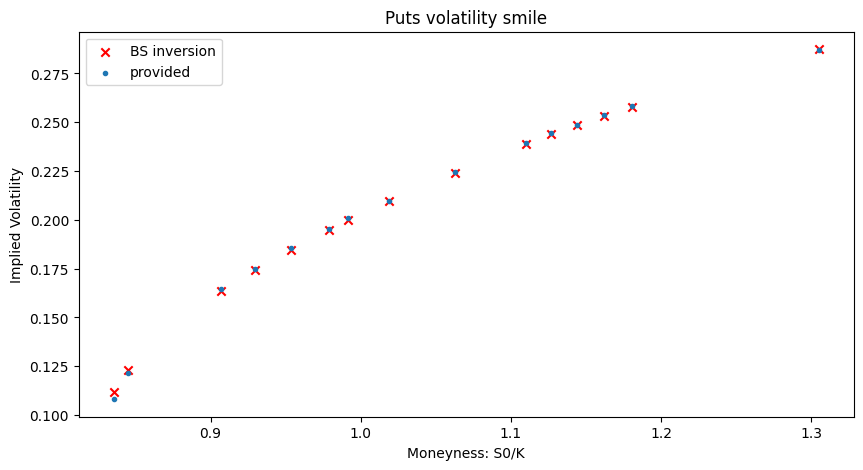

In [9]:
IV_market_p = []
for i in range(len(put_prices)):
    IV_market_p.append(implied_volatility(put_prices[i], S=S0, strike=put_strikes[i], t = T, rate=0.025, q = 0.05, type_o='put', method='fsolve'))

print(f'Implied volatilities of market prices (puts):\nS0 = {S0}')
for a,b in zip(put_strikes.head(6), IV_market_p[:6]):
    print(f'K = {a}, IV = {round(b, 4)}')

# Plot market implied volatilities w.r.t. log moneyness
x = (S0/put_strikes)
IV_filtered = [iv for iv in IV_market_p if iv != -1]
x_filtered = [log_m for iv, log_m in zip(IV_market_p, x) if iv != -1]
puts_filtered = [p_iv for iv, p_iv in zip(IV_market_p, puts['P_IV']) if iv != -1 ]

fig, ax1 = plt.subplots(figsize=(10,5))
ax1.scatter(x_filtered, IV_filtered, marker='x', label='BS inversion', color='red')
ax1.scatter(x_filtered, puts_filtered, marker='.', label='provided')
ax1.set_xlabel('Moneyness: S0/K'); ax1.set_ylabel('Implied Volatility'); ax1.set_title('Puts volatility smile')
ax1.legend(); plt.show()


##  Weighted Calibration (call options)
Let's step now into the calibration of model parameters.
If we define $\Theta$ the set of parameters, the goal is to find the optimal parameters $\Theta^*$ that minimize the following objective function:
$$ \sum_{i=1}^{N} w_i \biggl( P_i - f(K_i|\Theta) \biggr)^2 $$
where $w_i$ are weights, usually defined as
$$ w_i = \frac{1}{\text {spread}_i },$$ $P_i$ are the market prices and $f$ is the pricing function. In our case $f$ is given by **Merton** Jump Diffusion model, **Kou** Jump Diffusion model, or **Variance Gamma** process. To perform this optimization problem, many numerical methods can be used. In particular, we test two functions of `scipy.optimize`:
1. **curve_fit**, a least-squares curve fitting method which works with bounds. The default algorithm is [Trust Region Reflective (trf)](https://en.wikipedia.org/wiki/Trust_region). The [Levemberg-Marquadt](https://en.wikipedia.org/wiki/Levenberg%E2%80%93Marquardt_algorithm) has been tried as well, to test the optimization problem without setting boundaries, but the results don't make any sense.
2. **Least-Squares**, a constrained minimization problem which uses Trust region reflective method by default. This method is the most indicated to solve the non-linear least squares optimization problem of our purpose.
All the optimizations are carried out by initializing a starting point as the array $x_0 = [params]$ and setting feasible bounds.


In [10]:
put_spreads = puts['P_Spread']
p_weights = 1 / put_spreads**2

### Black and Scholes model
The only unknown parameter to calibrate in Black and Scholes model is the **implied volatility**, $\sigma$. Thus, we minimize the difference between the computed theoretical prices and the market prices of call options.

In [19]:
x0 = 0.5
bounds = [1e-5, 2]

def f_BlackScholes_puts(x, sigm):
    BS = BS_Pricer(S0=S0, K = x, ttm=T, r=r, q=0, sigma=sigm, exercise=exercise)
    return BS.closed_formula_put(x)

res1_puts = scpo.curve_fit(f_BlackScholes_puts, put_strikes, put_prices, p0 = x0, bounds=bounds, sigma=p_weights)
sigw_p = round(res1_puts[0][0],4)

In [20]:
def cost_function(x, strikes, mkt_prices):
    sigma = x
    BS = BS_Pricer(S0=S0, K = None, ttm=T, r=r, q=0, sigma=sigma, exercise=exercise)
    sq_err = np.sum( p_weights* (BS.closed_formula_put(strikes) - mkt_prices)**2)
    return sq_err

result_p = scpo.least_squares(cost_function, x0, args=(put_strikes, put_prices), bounds=bounds, method = 'trf', verbose=1)
opt_sigma_p = result_p.x[0]

`ftol` termination condition is satisfied.
Function evaluations 21, initial cost 4.8660e+08, final cost 1.8341e+04, first-order optimality 9.50e+01.


In [21]:
print('METHOD 1: CURVE_FIT (trf)')
print(f'> Calibrated Volatility from Calls [σ] = {sigw_p} \t {round(sigw_p*100,2)}%')
print('METHOD 2: LEAST-SQUARES (trf)')
print(f'> Calibrated Volatility from Calls [σ] = {opt_sigma_p} \t {round(opt_sigma_p*100,2)}%')

METHOD 1: CURVE_FIT (trf)
> Calibrated Volatility from Calls [σ] = 0.2831 	 28.31%
METHOD 2: LEAST-SQUARES (trf)
> Calibrated Volatility from Calls [σ] = 0.2791786438964399 	 27.92%


### Merton Jump Diffusion
The Merton Jump diffusion ones are the volatility $\sigma$, the Poisson rate of jumps $\lambda$, the mean rate of jump intensity $m$ and its variance rate $v$, assuming that the intensity of jumps follows a *Normal distribution*.


In [22]:
x0 = [0.15,  0.2, -0.05,  0.01]  # initial guess: [σ, λ, m, v]
bounds = ( [1e-3, 1e-2, -5, 1e-5], [2, 5, 5, 2] )

In [23]:
def f_Mert(x, sigma, lambd, meanJ, stdJ):
    Mert = Merton_pricer(S0=S0, K=x, ttm=T, r=r, q=0, sigma=sigma, lambd=lambd, meanJ=meanJ, stdJ=stdJ, exercise=exercise)
    return Mert.closed_formula_put(x)

start1=time.time()
mert1 = scpo.curve_fit(f_Mert, put_strikes, put_prices, p0=x0, bounds=bounds, sigma=put_spreads)
end1=time.time()

mert_params1 = [round(p,4) for p in mert1[0][:4]]

##### Method 2. Least-squares

In [24]:
x0 = [0.1,  0.5, 0.3,  0.1]      # initial guess: [σ, λ, m, v]
bounds = ( [1e-3, 1e-2, -10, 0], [2, np.inf, 10, 5] )

def cost_function(x, strikes, mkt_prices):
    sigma, lambd, meanJ, stdJ = x
    M = Merton_pricer(S0, None, T, r, q, sigma, lambd, meanJ, stdJ, exercise)
    sq_err = np.sum( p_weights*(M.closed_formula_put(strikes) - mkt_prices)**2)
    return sq_err

start2 = time.time()
mert2 = scpo.least_squares(cost_function, x0, args=(put_strikes, put_prices), bounds=bounds, method = 'trf', verbose=2)
end2 = time.time()

mert_params2 = [round(p,4) for p in mert2.x[:4]]

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.0194e+06                                    2.66e+08    
       1              3         6.7292e+05      3.47e+05       1.30e-01       2.44e+08    
       2              6         4.1625e+05      2.57e+05       2.58e-02       1.32e+07    
       3              7         3.7965e+05      3.66e+04       1.21e-02       6.82e+07    
       4              9         3.4899e+05      3.07e+04       6.37e-03       2.58e+07    
       5             10         3.3359e+05      1.54e+04       5.33e-03       1.10e+07    
       6             11         3.0470e+05      2.89e+04       5.50e-03       1.75e+07    
       7             12         2.7703e+05      2.77e+04       1.90e-02       4.04e+07    
       8             14         2.5192e+05      2.51e+04       5.12e-03       1.26e+07    
       9             15         2.3576e+05      1.62e+04       7.56e-03       2.83e+07    

In [25]:
print('WEIGHTED OPT: CURVE_FIT (trf)')
print(f'> Calibrated Volatlity [σ] = {round(mert1[0][0],4)} \t {round(mert1[0][0]*100,2)}%')
print('> Calibrated Jump intensity [λ] = ', round(mert1[0][1],2))
print('> Calibrated Jump Mean = ', round(mert1[0][2],2))
print('> Calibrated Jump St. dev.  = ', round(mert1[0][3],5))
print(f'ELAPSED TIME: {end1-start1} sec')

print('\nMETHOD 1: LEAST SQUARES (trf)')
print(f'> Calibrated Volatlity [σ] = {mert_params2[0]} \t {round(mert_params2[0]*100,2)}%')
print('> Calibrated Jump intensity [λ] = ', round(mert_params2[1],2))
print('> Calibrated Jump Mean = ', round(mert_params2[2],3))
print('> Calibrated Jump St. dev.  = ', round(mert_params2[3],3))
print(f'TIME ELAPSED:  {round(end2-start2,2)} sec')

WEIGHTED OPT: CURVE_FIT (trf)
> Calibrated Volatlity [σ] = 0.0737 	 7.37%
> Calibrated Jump intensity [λ] =  0.83
> Calibrated Jump Mean =  -0.07
> Calibrated Jump St. dev.  =  0.33694
ELAPSED TIME: 8.492132663726807 sec

METHOD 1: LEAST SQUARES (trf)
> Calibrated Volatlity [σ] = 0.1382 	 13.82%
> Calibrated Jump intensity [λ] =  0.61
> Calibrated Jump Mean =  -0.084
> Calibrated Jump St. dev.  =  0.357
TIME ELAPSED:  66.21 sec


In [26]:
print(mert_params1)
print(mert_params2)

[0.0737, 0.8324, -0.0669, 0.3369]
[0.1382, 0.6087, -0.0842, 0.357]


### Kou Jump Diffusion


In [27]:
x0 = [0.3, 0.8, 0.5, 5, 10] # initial guess: [σ, λ, p, η_1, η_2]
bounds = ( [1e-2, 1e-1, 0, 0.5, 0.5], [0.5, 4, 1, 15, 20] )

##### Method 1. TRF (Bounds)

In [28]:
# def f_Kou(x, sigma, lambd, p, eta1, eta2):
#     KouJD = Kou_pricer(S0=S0, K=x, ttm=T, r=r, sigma=sigma, lambd=lambd, p=p, eta1=eta1, eta2=eta2, exercise=exercise)
#     return KouJD.closed_formula_put(x)
#
# start1 = time.time()
# kou1 = scpo.curve_fit(f_Kou, put_strikes, put_prices, p0=x0, bounds=bounds, sigma=p_weights)
# end1 = time.time()
#
# kou_params1 = [round(p,4) for p in kou1[0][:5]]

##### Method 2. LEAST SQUARES (With Bounds)

In [29]:
# Define the objective function
def cost_function(x, strikes, mkt_prices):
    sigm, lamb, p, eta1, eta2 = x
    KOU = Kou_pricer(S0=S0, K=strikes, ttm=T, r=r, sigma=sigm, lambd=lamb, p=p, eta1=eta1, eta2=eta2, exercise=exercise)
    sq_err = np.sum(p_weights*(KOU.closed_formula_put(strikes) - mkt_prices)**2)
    return sq_err

start2=time.time()
kou2 = scpo.least_squares(cost_function, x0, args=(put_strikes, put_prices),  method='trf', bounds=bounds, verbose=2)
end2=time.time()

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.0134e+07                                    1.17e+08    
       1              3         3.5070e+05      9.78e+06       2.95e+00       7.47e+06    
       2              4         9.1771e+03      3.42e+05       5.74e+00       6.45e+04    
       3              8         8.8378e+03      3.39e+02       4.91e-03       3.74e+04    
       4             10         8.7941e+03      4.37e+01       1.58e-03       3.17e+03    
       5             12         8.7929e+03      1.15e+00       2.84e-04       8.18e+03    
       6             13         8.7925e+03      4.92e-01       6.99e-04       3.29e+03    
       7             14         8.7917e+03      7.19e-01       6.90e-05       2.64e+03    
       8             15         8.7909e+03      8.12e-01       2.00e-04       5.60e+03    
       9             16         8.7901e+03      7.98e-01       4.15e-04       4.71e+03    

In [30]:
kou_params2 = [round(p,4) for p in kou2.x[:5]]

In [31]:
# print('WEIGHTED OPT: CURVE_FIT (trf)')
# print(f'> Calibrated Volatlity [σ] = {kou_params1[0]} \t {kou_params1[0] * 100}%')
# print('> Calibrated Jump intensity [λ] = ', kou_params1[1])
# print(f'> Calibrated Upward Jump probability [p] = {kou_params1[2]}, [q] = {round(1 - kou_params1[2], 2)}')
# print('> Calibrated Rate of Exp. 1  [η_1] = ', kou_params1[3])
# print('> Calibrated Rate of Exp. 2  [η_2] = ', kou_params1[4])
# print(f'TIME ELAPSED: {end1-start1} sec')

In [32]:
print('METHOD 2: Least-squares')
print(f'> Calibrated Volatlity [σ] = {round(kou_params2[0],4)} \t {round(kou_params2[0]*100,2)}%')
print('> Calibrated Jump intensity [λ] = ', round(kou_params2[1],2))
print(f'> Calibrated Upward Jump probability [p] = {round(kou_params2[2],2)}, [q] = {round(1-kou_params2[2],2)}')
print('> Calibrated Rate of Exp. 1  [η_1] = ', round(kou_params2[3],2))
print('> Calibrated Rate of Exp. 2  [η_2] = ', round(kou_params2[4],2))
print(f'TIME ELAPSED:  {round(end2-start2,2)} sec')

METHOD 2: Least-squares
> Calibrated Volatlity [σ] = 0.2193 	 21.93%
> Calibrated Jump intensity [λ] =  0.72
> Calibrated Upward Jump probability [p] = 0.43, [q] = 0.57
> Calibrated Rate of Exp. 1  [η_1] =  11.27
> Calibrated Rate of Exp. 2  [η_2] =  4.57
TIME ELAPSED:  5964.37 sec


In [33]:
#print(kou_params1)
print(kou_params2)

[0.2193, 0.7222, 0.4273, 11.2726, 4.5653]


### Variance Gamma


In [34]:
x0 = [0.2, -0.3, 0.1]   # initial guess: [σ, θ, v]
bounds = ( [1e-3, -5, 0], [3, 5, 10] )

##### Method 1. CURVE FIT (Bounds)

In [35]:
def f_VG(strikes, sigmax, thetax, nux):
    VGamma = VG_pricer(S0=S0, K=None, ttm=T, r=r, q=0, sigma=sigmax, theta=thetax, nu=nux, exercise='put')
    vg_prices = []
    for k in strikes:
        vg_prices.append(VGamma.closed_formula_put(k))
    return vg_prices

start1 = time.time()
vg1 = scpo.curve_fit(f_VG, put_strikes, put_prices, p0=x0, bounds=bounds, sigma=p_weights)
end1 = time.time()

vg_params1 = [round(p,4) for p in vg1[0][:3]]

##### Method 2. LEAST-SQUARES (Trust Region Reflective, Bounds)

In [36]:
def cost_function(x, strikes, mkt_prices):
    sigma, theta, nu = x
    VG = VG_pricer(S0, None, T, r, q, sigma, theta, nu, exercise)
    prices = []
    for k in strikes:
        prices.append(VG.closed_formula_put(k))
    sq_err = np.sum(p_weights*(prices - mkt_prices)**2)
    return sq_err

start2=time.time()
vg2 = scpo.least_squares(cost_function, x0, args=(put_strikes, put_prices),  method='trf', bounds=bounds, verbose=2, loss='soft_l1')
end2=time.time()

vg_params2 = [round(p,4) for p in vg2.x[:3]]

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.0755e+03                                    1.58e+05    
       1              3         6.4388e+02      1.43e+03       9.11e-02       3.09e+04    
       2              4         3.1663e+02      3.27e+02       7.91e-02       2.05e+04    
       3              7         2.9320e+02      2.34e+01       4.83e-03       6.24e+03    
       4              9         2.9115e+02      2.05e+00       1.21e-03       2.87e+03    
       5             10         2.9015e+02      1.00e+00       1.30e-03       2.97e+03    
       6             11         2.8918e+02      9.65e-01       1.60e-03       2.82e+03    
       7             12         2.8726e+02      1.92e+00       3.13e-03       3.01e+03    
       8             13         2.8388e+02      3.38e+00       6.41e-03       3.00e+03    
       9             15         2.8283e+02      1.06e+00       2.59e-03       3.73e+03    

In [38]:
print('WEIGHTED OPT: CURVE_FIT (trf)')
print(f'> Calibrated Volatlity [σ] = {vg_params1[0]}, \t {round(vg_params1[0]*100,2)}%')
print('> Calibrated mean rate gamma process [θ] = ', vg_params1[1])
print('> Calibrated variance rate gamma process [v]= ', vg_params1[2])
print(f'TIME ELAPSED:  {round(end1-start1,2)} sec')

print('METHOD 1: LEAST-SQUARES (trf)')
print(f'> Calibrated Volatlity [σ] = {vg_params2[0]}, \t {round(vg_params2[0]*100,2)}%')
print('> Calibrated mean rate gamma process [θ] = ', vg_params2[1])
print('> Calibrated variance rate gamma process [v]= ', vg_params2[2])
print(f'TIME ELAPSED:  {round(end2-start2,2)} sec')

WEIGHTED OPT: CURVE_FIT (trf)
> Calibrated Volatlity [σ] = 0.3612, 	 36.12%
> Calibrated mean rate gamma process [θ] =  0.0721
> Calibrated variance rate gamma process [v]=  3.5593
TIME ELAPSED:  48.07 sec
METHOD 1: LEAST-SQUARES (trf)
> Calibrated Volatlity [σ] = 0.2962, 	 29.62%
> Calibrated mean rate gamma process [θ] =  0.0778
> Calibrated variance rate gamma process [v]=  0.6548
TIME ELAPSED:  530.6 sec


In [39]:
print(vg_params1)
print(vg_params2)

[0.3612, 0.0721, 3.5593]
[0.2962, 0.0778, 0.6548]


### Reprice of options using calibrated parameters
The following code snippet aims to find the best parameters for each model, minimizing the difference between the monte carlo prices and the market prices of **call** and **put** options.

In [40]:
days = 252
paths = 5000

put_calib_prices = pd.DataFrame({
    'STRIKE': puts['STRIKE'],    # array of K for call options
    'MKT_BID': puts['P_BID'],
    'MKT_MID': puts['P_Midpoint'],
    'MKT_ASK': puts['P_ASK'],

})
print(f'MARKET PRICES. STARTING DATE = 20-01-2016. EXPIRY = 1YEAR. \n\n{put_calib_prices}')

MARKET PRICES. STARTING DATE = 20-01-2016. EXPIRY = 1YEAR. 

    STRIKE  MKT_BID  MKT_MID  MKT_ASK
0   1475.0    57.20   58.495    59.79
1   1500.0    61.61   62.955    64.30
2   1650.0    94.79   96.245    97.70
3   1675.0   101.59  103.090   104.59
4   1700.0   108.51  110.055   111.60
5   1725.0   116.50  118.100   119.70
6   1775.0   133.01  134.655   136.30
7   1800.0   142.29  143.950   145.61
8   1825.0   152.01  153.710   155.41
9   1950.0   210.00  211.850   213.70
10  2000.0   237.90  239.850   241.80
11  2025.0   252.99  254.995   257.00
12  2050.0   268.89  270.945   273.00
13  2125.0   321.20  323.350   325.50
14  2175.0   360.29  362.495   364.70
15  2275.0   446.30  448.695   451.09
16  2300.0   469.20  471.700   474.20
17  2425.0   588.81  591.410   594.01


#### Merton Jump Diffusion model

In [41]:
#mert_params2 = [0.1267, 0.951, -0.1182, 0.2691]
sigma, lambd, meanJ, stdJ = mert_params2
MertonCAL = Merton_pricer(S0, None, T, r, q, sigma, lambd, meanJ, stdJ, exercise)
SMerton_CAL = MertonCAL.MertonPath(days, paths)

avg_payoffs = []
for K in put_strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for St in SMerton_CAL[-1]:
        payoffs.append(MertonCAL.payoff_put(K, St))
    avg_payoffs.append(np.mean(payoffs))

merton_mc_prices = np.zeros(len(put_calib_prices))
merton_cf_prices = np.zeros(len(put_calib_prices))

for index in range(len(put_calib_prices)):
    merton_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index]
    merton_cf_prices[index] = MertonCAL.closed_formula_put(put_strikes[index])

put_calib_prices['MERTON MC'] = merton_mc_prices
put_calib_prices['MERTON CF'] = merton_cf_prices

print(put_calib_prices)

    STRIKE  MKT_BID  MKT_MID  MKT_ASK   MERTON MC   MERTON CF
0   1475.0    57.20   58.495    59.79   55.157663   56.340191
1   1500.0    61.61   62.955    64.30   59.502188   60.743449
2   1650.0    94.79   96.245    97.70   92.466193   94.282978
3   1675.0   101.59  103.090   104.59   99.361122  101.343082
4   1700.0   108.51  110.055   111.60  106.701982  108.907087
5   1725.0   116.50  118.100   119.70  114.613740  117.004264
6   1775.0   133.01  134.655   136.30  132.134493  134.902165
7   1800.0   142.29  143.950   145.61  141.731068  144.746444
8   1825.0   152.01  153.710   155.41  151.909424  155.209946
9   1950.0   210.00  211.850   213.70  212.128287  217.040192
10  2000.0   237.90  239.850   241.80  240.462500  246.136527
11  2025.0   252.99  254.995   257.00  255.482551  261.566102
12  2050.0   268.89  270.945   273.00  271.057984  277.555124
13  2125.0   321.20  323.350   325.50  321.136048  328.629030
14  2175.0   360.29  362.495   364.70  356.843897  364.995192
15  2275

In [42]:
#kou_params2 = [0.1278, 0.948, 0.3549, 5.7153, 4.232]
sigma, lambd, p, eta1, eta2 = kou_params2
KouCAL = Kou_pricer(S0, None, T, r, sigma, lambd, p, eta1, eta2, exercise)
SKou_CAL = KouCAL.KouPath(days, paths)

avg_payoffs = []
for k in put_strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for St in SKou_CAL[-1]:
        payoffs.append(KouCAL.payoff_put(k, St))
    avg_payoffs.append(np.mean(payoffs))

kou_mc_prices = np.zeros(len(put_calib_prices))
kou_cf_prices = np.zeros(len(put_calib_prices))

for index in range(len(put_calib_prices)):
    kou_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index]
    kou_cf_prices[index] = KouCAL.closed_formula_put(put_strikes[index])

put_calib_prices['KOU MC'] = kou_mc_prices
put_calib_prices['KOU CF'] = kou_cf_prices

print(put_calib_prices)

    STRIKE  MKT_BID  MKT_MID  MKT_ASK   MERTON MC   MERTON CF      KOU MC   
0   1475.0    57.20   58.495    59.79   55.157663   56.340191   50.206798  \
1   1500.0    61.61   62.955    64.30   59.502188   60.743449   55.074610   
2   1650.0    94.79   96.245    97.70   92.466193   94.282978   93.127986   
3   1675.0   101.59  103.090   104.59   99.361122  101.343082  100.989287   
4   1700.0   108.51  110.055   111.60  106.701982  108.907087  109.314679   
5   1725.0   116.50  118.100   119.70  114.613740  117.004264  118.077984   
6   1775.0   133.01  134.655   136.30  132.134493  134.902165  137.052888   
7   1800.0   142.29  143.950   145.61  141.731068  144.746444  147.261527   
8   1825.0   152.01  153.710   155.41  151.909424  155.209946  158.018577   
9   1950.0   210.00  211.850   213.70  212.128287  217.040192  219.518640   
10  2000.0   237.90  239.850   241.80  240.462500  246.136527  247.616331   
11  2025.0   252.99  254.995   257.00  255.482551  261.566102  262.352320   

In [43]:
# vg_params2 = [0.2442, 0.1983, 0.9451]
sigma, theta, nu = vg_params2
VGCAL = VG_pricer(S0, None, T, r, q, sigma, theta, nu, exercise)
SVarGamma_CAL = VGCAL.VarianceGammaPath1(days, paths)

avg_payoffs = []
for K in put_strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for St in SVarGamma_CAL[-1]:
        payoffs.append(VGCAL.payoff_put(K, St))
    avg_payoffs.append(np.mean(payoffs))

vg_mc_prices = np.zeros(len(put_calib_prices))
vg_cf_prices = np.zeros(len(put_calib_prices))

for index in range(len(put_calib_prices)):
    vg_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index]
    vg_cf_prices[index] = VGCAL.closed_formula_put(put_strikes[index])

put_calib_prices['VG MC'] = vg_mc_prices
put_calib_prices['VG CF'] = vg_cf_prices

print(put_calib_prices)

    STRIKE  MKT_BID  MKT_MID  MKT_ASK   MERTON MC   MERTON CF      KOU MC   
0   1475.0    57.20   58.495    59.79   55.157663   56.340191   50.206798  \
1   1500.0    61.61   62.955    64.30   59.502188   60.743449   55.074610   
2   1650.0    94.79   96.245    97.70   92.466193   94.282978   93.127986   
3   1675.0   101.59  103.090   104.59   99.361122  101.343082  100.989287   
4   1700.0   108.51  110.055   111.60  106.701982  108.907087  109.314679   
5   1725.0   116.50  118.100   119.70  114.613740  117.004264  118.077984   
6   1775.0   133.01  134.655   136.30  132.134493  134.902165  137.052888   
7   1800.0   142.29  143.950   145.61  141.731068  144.746444  147.261527   
8   1825.0   152.01  153.710   155.41  151.909424  155.209946  158.018577   
9   1950.0   210.00  211.850   213.70  212.128287  217.040192  219.518640   
10  2000.0   237.90  239.850   241.80  240.462500  246.136527  247.616331   
11  2025.0   252.99  254.995   257.00  255.482551  261.566102  262.352320   

### Visualize calibration results
#### Closed Formulas Option pricing

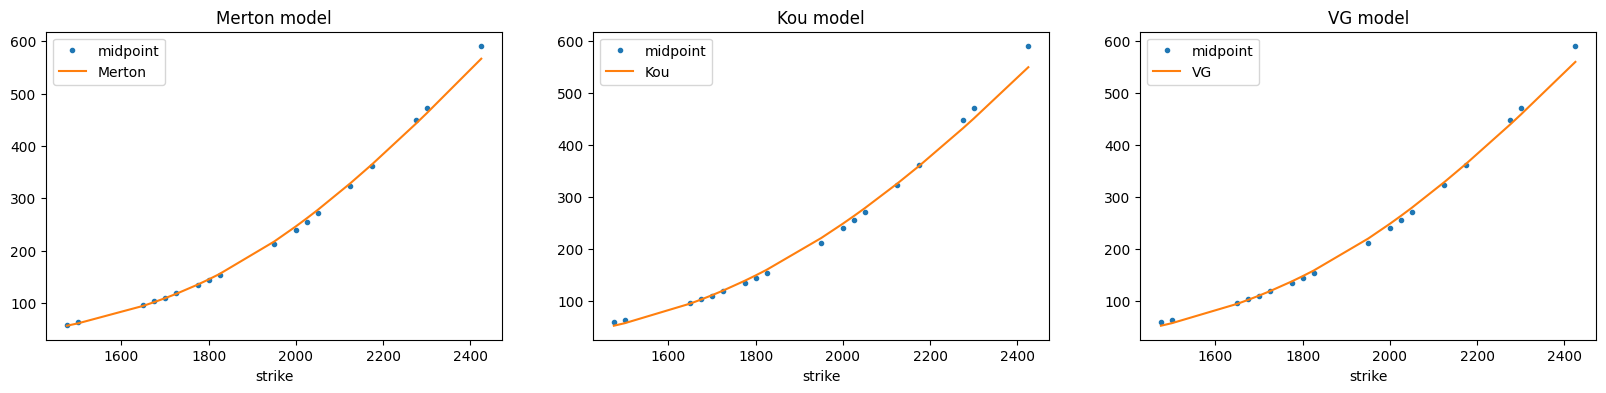

In [46]:
fig = plt.figure(figsize=(20, 4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax1.plot(put_strikes, put_prices, ".", label="midpoint")
ax2.plot(put_strikes, put_prices, ".", label="midpoint")
ax3.plot(put_strikes, put_prices, ".", label="midpoint")
ax1.plot(put_strikes, merton_cf_prices, label="Merton")
ax2.plot(put_strikes, kou_cf_prices, label="Kou")
ax3.plot(put_strikes, vg_cf_prices, label="VG")
ax1.set_title("Merton model")
ax2.set_title("Kou model")
ax3.set_title("VG model")
ax1.set_xlabel("strike")
ax2.set_xlabel("strike")
ax3.set_xlabel("strike")
ax1.legend()
ax2.legend()
ax3.legend()
plt.show()


#### Monte Carlo option pricing

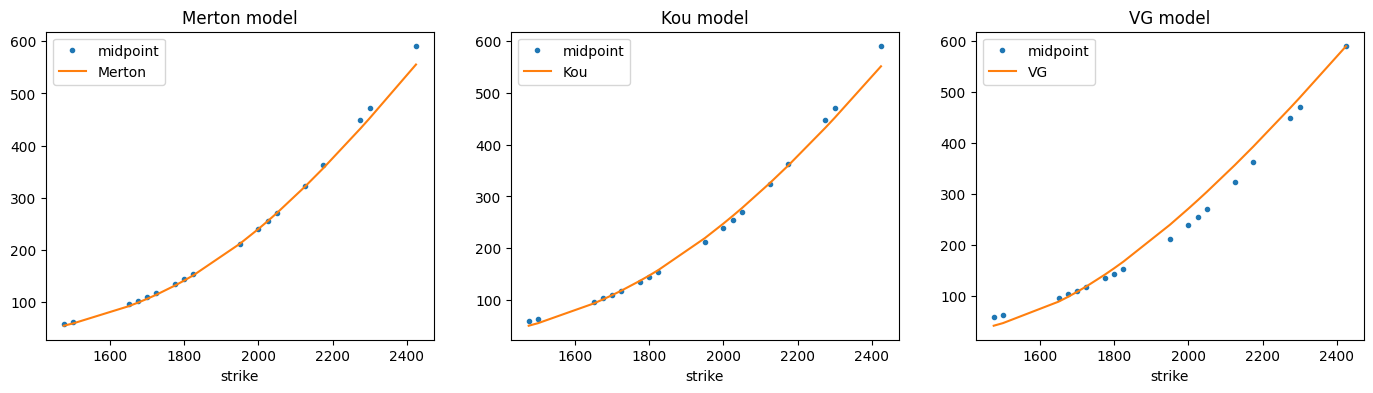

In [45]:
fig = plt.figure(figsize=(17, 4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax1.plot(put_strikes, put_prices, ".", label="midpoint")
ax2.plot(put_strikes, put_prices, ".", label="midpoint")
ax3.plot(put_strikes, put_prices, ".", label="midpoint")
ax1.plot(put_strikes, merton_mc_prices, label="Merton")
ax2.plot(put_strikes, kou_mc_prices, label="Kou")
ax3.plot(put_strikes, vg_mc_prices, label="VG")
ax1.set_title("Merton model")
ax2.set_title("Kou model")
ax3.set_title("VG model")
ax1.set_xlabel("strike")
ax2.set_xlabel("strike")
ax3.set_xlabel("strike")
ax1.legend()
ax2.legend()
ax3.legend()
plt.show()